In [62]:
from utils.sceneflow_util import add_pose
import torch


pose_mat = torch.cat([torch.rand(3, 3), torch.zeros(3, 1)], dim=1).unsqueeze(0)
pose_res = torch.tensor([[0, 0, 0.3, 0, 0, 0]]).float()

print(pose_mat)

pose_mat = add_pose(pose_mat, pose_res)
pose_mat = add_pose(pose_mat, pose_res)
print(pose_mat)

tensor([[[0.7206, 0.7675, 0.5116, 0.0000],
         [0.4900, 0.0337, 0.6823, 0.0000],
         [0.8282, 0.0746, 0.1576, 0.0000]]])
tensor([[[0.7206, 0.7675, 0.5116, 0.0000],
         [0.4900, 0.0337, 0.6823, 0.0000],
         [0.8282, 0.0746, 0.1576, 0.6000]]])


In [1]:
%load_ext autoreload
def train_one_epoch(args, model, loss, dataloader, optimizer, augmentations, lr_scheduler):

    loss_dict_avg = None

    for data in dataloader:
        loss_dict, output_dict = step(args, data, model, loss, augmentations, optimizer)
        
        if loss_dict_avg is None:
            loss_dict_avg = {k:0 for k in loss_dict}

        if optimizer is not None:
            # calculate gradients and then do Adam step
            optimizer.zero_grad()
            
        total_loss = loss_dict['total_loss']
        
        if optimizer is not None:
            total_loss.backward()
            optimizer.step()

        for key in loss_dict.keys():
            loss_dict_avg[key] += loss_dict[key]

        n = len(dataloader)
        for key in loss_dict.keys():
            loss_dict_avg[key] /= n
        
    return loss_dict_avg, output_dict, data
 
def step(args, data_dict, model, loss, augmentations, optimizer):
    start = time()
    # Get input and target tensor keys
    input_keys = list(filter(lambda x: "input" in x, data_dict.keys()))
    target_keys = list(filter(lambda x: "target" in x, data_dict.keys()))
    tensor_keys = input_keys + target_keys
    debug_keys = ['input_l1', 'input_l2', 'input_r1', 'input_r2']

    # Possibly transfer to Cuda
    if args.cuda:
        for k, v in data_dict.items():
            if k in tensor_keys:
                data_dict[k] = v.cuda(non_blocking=True)

    if augmentations is not None:
        with torch.no_grad():
            data_dict = augmentations(data_dict)

    for k, t in data_dict.items():
        if k in input_keys:
            data_dict[k] = t.requires_grad_(True)
        if k in target_keys:
            data_dict[k] = t.requires_grad_(False)

        output_dict = model(data_dict)
        loss_dict = loss(output_dict, data_dict)

        training_loss = loss_dict['total_loss']
        assert (not torch.isnan(training_loss)), "training_loss is NaN"

    return loss_dict, output_dict

In [5]:
%autoreload
import torch
from tqdm import tqdm
from time import time
from torch.optim import Adam
from models.SceneNet import SceneNet
from torch.utils.data import DataLoader
from augmentations import Augmentation_Resize_Only, Augmentation_SceneFlow
from models.model_monosceneflow import MonoSceneFlow
from models.encoders import ResNetEncoder, PWCEncoder
from datasets.kitti_raw_monosf import KITTI_Raw_KittiSplit_Train, KITTI_Raw_KittiSplit_Valid

from collections import OrderedDict

class Args:
    cuda = True
    model_name = 'scenenet'
    use_bn = False
    encoder_name = 'pwc'
    evaluation = False
    finetuning = False
    momentum = 0.9
    beta = 0.999
    weight_decay=0.0
    use_mask = True
    disp_lr_w = 1.0
    pose_sm_w = 200
    disp_smooth_w = 0.1
    mask_reg_w = 0.1
    static_cons_w = 0.0
    mask_cons_w = 0.0
    mask_sm_w = 0.1
    flow_diff_thresh=1e-3
    test = True
    
    
args = Args()

# model = SceneNetStereoShared(args).cuda()

# augmentations = Augmentation_Resize_Only(args, photometric=False).cuda()
# optimizer = Adam(model.parameters(), lr=2e-4, betas=[args.momentum, args.beta], weight_decay=args.weight_decay)

data_root = '/external/datasets/kitti_data_jpg/'
val_dataset = KITTI_Raw_KittiSplit_Valid(args, root=data_root, num_examples=100)
val_loader = DataLoader(val_dataset, batch_size=1)
# loss = Loss_SceneFlow_SelfSup_JointStereo(args)
# train_one_epoch(args, model, loss, train_loader, optimizer, augmentations, None)

In [7]:
for i, data in enumerate(val_loader):
    print(i, data['input_l1'].shape)

0 torch.Size([1, 3, 375, 1242])
1 torch.Size([1, 3, 375, 1242])
2 torch.Size([1, 3, 375, 1242])
3 torch.Size([1, 3, 375, 1242])
4 torch.Size([1, 3, 375, 1242])
5 torch.Size([1, 3, 375, 1242])
6 torch.Size([1, 3, 375, 1242])
7 torch.Size([1, 3, 375, 1242])
8 torch.Size([1, 3, 375, 1242])
9 torch.Size([1, 3, 375, 1242])
10 torch.Size([1, 3, 375, 1242])
11 torch.Size([1, 3, 375, 1242])
12 torch.Size([1, 3, 375, 1242])
13 torch.Size([1, 3, 375, 1242])
14 torch.Size([1, 3, 375, 1242])
15 torch.Size([1, 3, 375, 1242])
16 torch.Size([1, 3, 375, 1242])
17 torch.Size([1, 3, 375, 1242])
18 torch.Size([1, 3, 375, 1242])
19 torch.Size([1, 3, 375, 1242])
20 torch.Size([1, 3, 375, 1242])
21 torch.Size([1, 3, 375, 1242])
22 torch.Size([1, 3, 375, 1242])
23 torch.Size([1, 3, 375, 1242])
24 torch.Size([1, 3, 375, 1242])
25 torch.Size([1, 3, 375, 1242])
26 torch.Size([1, 3, 375, 1242])
27 torch.Size([1, 3, 375, 1242])
28 torch.Size([1, 3, 375, 1242])
29 torch.Size([1, 3, 375, 1242])
30 torch.Size([1, 3,

KeyboardInterrupt: 

TypeError: Invalid shape (3, 375, 1242) for image data

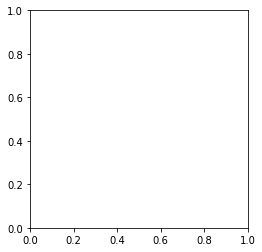

In [7]:
import matplotlib.pyplot as plt

l1 = train_dataset[0]['input_l1']
r1 = train_dataset[0]['input_r1']

plt.imshow(l1)
plt.show()
plt.imshow(r1)
plt.show()

In [21]:
torch.inverse(train_dataset[0]['input_cam_l2r'][:3, :3]), -train_dataset[0]['input_cam_l2r'][:, 3]

(tensor([[ 0.9996, -0.0223,  0.0197],
         [ 0.0223,  0.9998, -0.0011],
         [-0.0197,  0.0015,  0.9998]]),
 tensor([ 0.5326, -0.0066,  0.0090]))